In [1]:
import os
import glob
import tqdm
import scipy
import matplotlib
import numpy as np
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt

## Functional connectivity cortex vs. cerebellum

In [2]:
systems = [
    ['LangLoc','MDLoc','Cerebellum1'],
    ['LangLoc','MDLoc','Cerebellum2'],
    ['LangLoc','MDLoc','Cerebellum3'],
    ['LangLoc','Cerebellum1'],
    ['LangLoc','Cerebellum2'],
    ['LangLoc','Cerebellum3'],
    ['LangLoc','Cerebellum4'] # Cerebellum1 with IX
]

In [15]:
for task in ['AliceLong','RS']:

    for system in systems:
        system_string = '_'.join(system)
        print(task+' '+system_string)
        
        # load data
        data = pd.DataFrame()
        for sys in system:
            if sys=='Cerebellum4':
                data1 = pd.read_csv('extraction/output/Alice_'+task+'_TimeSeries_Cerebellum1.csv')
                data2 = pd.read_csv('extraction/output/Alice_'+task+'_TimeSeries_Cerebellum3.csv')
                data2 = data2.loc[data2.ROI=='Right_IX']
                data = pd.concat([data,data1,data2])
            else:
                data1 = pd.read_csv('extraction/output/Alice_'+task+'_TimeSeries_'+sys+'.csv')
                data = pd.concat([data,data1])
        if 'MDLoc' in system_string: # exclude RH MD
            idxs_keep = np.array([True if ROI not in ['MD_RH_postParietal',
                                                      'MD_RH_midParietal',
                                                      'MD_RH_antParietal',
                                                      'MD_RH_supFrontal',
                                                      'MD_RH_Precentral A PrecG',
                                                      'MD_RH_Precentral B IFGop',
                                                      'MD_RH_midFrontal',
                                                      'MD_RH_midFrontalOrb',
                                                      'MD_RH_insula',
                                                      'MD_RH_medialFrontal'] else False for ROI in data.ROI])
            data = data.loc[idxs_keep,:]
        ROIs = pd.unique(data.ROI)
        nROIs = len(ROIs)
        subs = pd.unique(data.SessionCritical)
        nsubs = len(subs)
        
        # matrix of correlations to fill
        corrs = np.zeros((nROIs*nsubs,nROIs))
        pvals = np.zeros((nROIs*nsubs,nROIs))

        s_start = 0
        for s,sub in tqdm.tqdm(enumerate(subs)):
            data_sub = data.loc[data.SessionCritical==sub]
    
            for r1,roi1 in enumerate(ROIs):
                for r2,roi2 in enumerate(ROIs):

                    if roi1==roi2:
                        corrs[r1+s_start,r2] = np.nan
                        pvals[r1+s_start,r2] = np.nan
                    else:
                        if task=='AliceLong':
                            x = np.squeeze(data_sub.loc[data_sub.ROI==roi1].iloc[:,14:-6].values)
                            y = np.squeeze(data_sub.loc[data_sub.ROI==roi2].iloc[:,14:-6].values)
                        elif task=='RS':
                            x = np.squeeze(data_sub.loc[data_sub.ROI==roi1].iloc[:,4:].values)
                            y = np.squeeze(data_sub.loc[data_sub.ROI==roi2].iloc[:,4:].values)
                        result = scipy.stats.pearsonr(x,y)
                        # corrs[r1+s_start,r2] = np.arctanh(result.statistic) # Fisher Transform
                        corrs[r1+s_start,r2] = result.statistic
                        pvals[r1+s_start,r2] = result.pvalue
                    
            s_start = s_start+nROIs
            
        # save corrs
        multi = pd.MultiIndex.from_product([subs,ROIs],names=['Subjects','ROIs'])
        corrs_output = pd.DataFrame(corrs,columns=ROIs,index=multi)
        corrs_output.to_csv('Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficients_no_fixation.csv')
        pvals_output = pd.DataFrame(pvals,columns=ROIs,index=multi)
        pvals_output.to_csv('Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficient_pvalues_no_fixation.csv')

AliceLong LangLoc_MDLoc_Cerebellum1


85it [01:21,  1.04it/s]


AliceLong LangLoc_MDLoc_Cerebellum2


85it [01:50,  1.30s/it]


AliceLong LangLoc_MDLoc_Cerebellum3


85it [01:55,  1.36s/it]


AliceLong LangLoc_Cerebellum1


85it [00:30,  2.81it/s]


AliceLong LangLoc_Cerebellum2


85it [00:47,  1.79it/s]


AliceLong LangLoc_Cerebellum3


85it [00:52,  1.62it/s]


AliceLong LangLoc_Cerebellum4


85it [00:34,  2.46it/s]


RS LangLoc_MDLoc_Cerebellum1


85it [01:22,  1.03it/s]


RS LangLoc_MDLoc_Cerebellum2


85it [01:48,  1.27s/it]


RS LangLoc_MDLoc_Cerebellum3


85it [01:53,  1.34s/it]


RS LangLoc_Cerebellum1


85it [00:28,  2.93it/s]


RS LangLoc_Cerebellum2


85it [00:43,  1.94it/s]


RS LangLoc_Cerebellum3


85it [00:47,  1.79it/s]


RS LangLoc_Cerebellum4


85it [00:30,  2.77it/s]


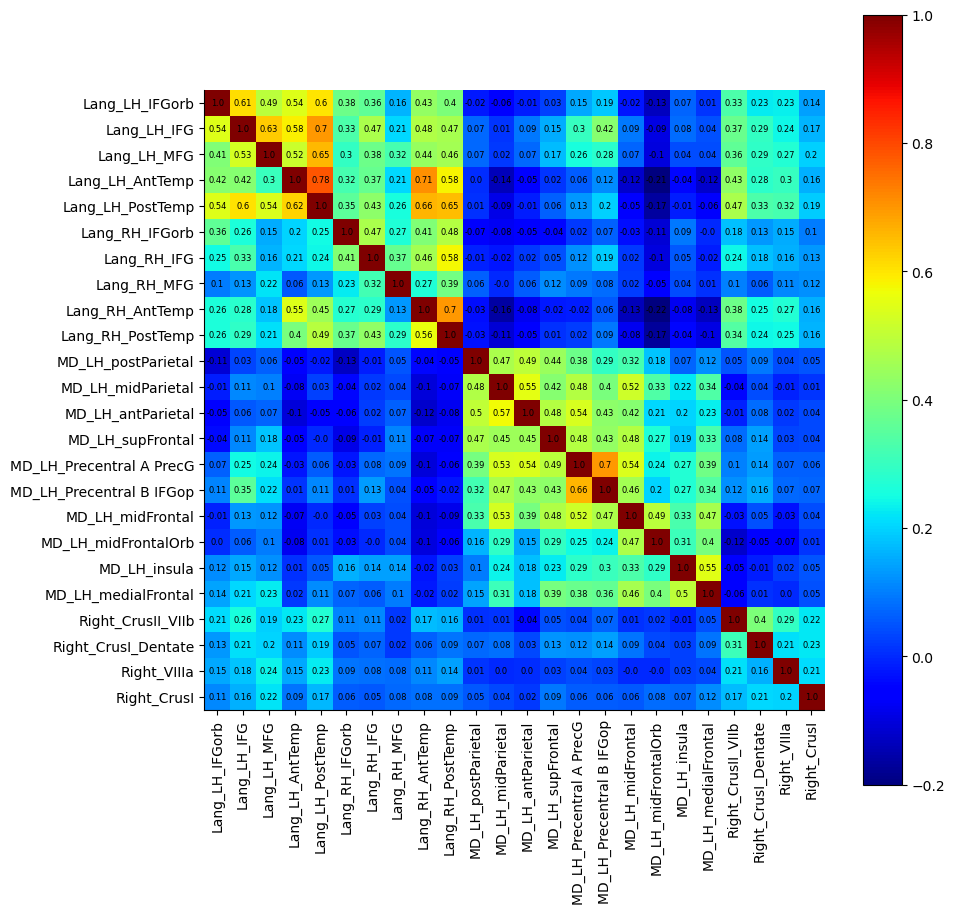

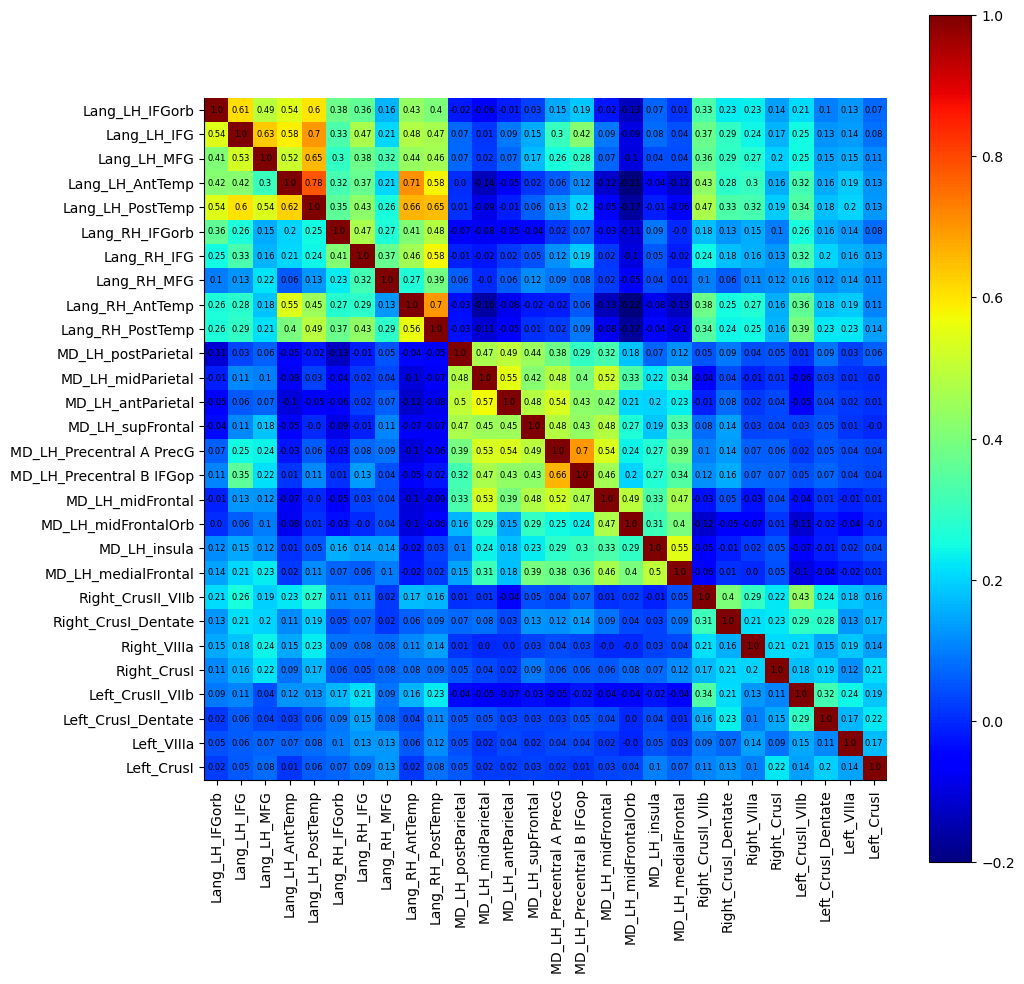

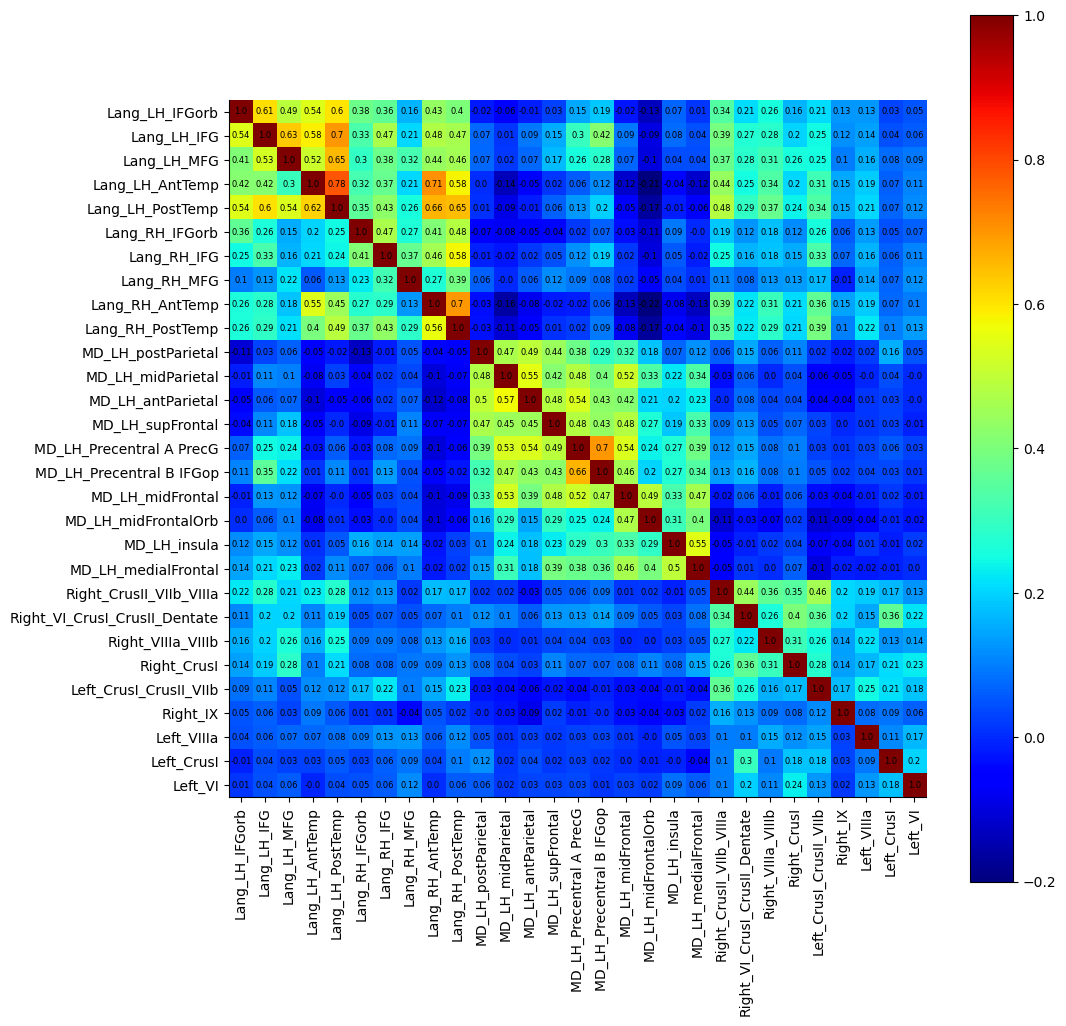

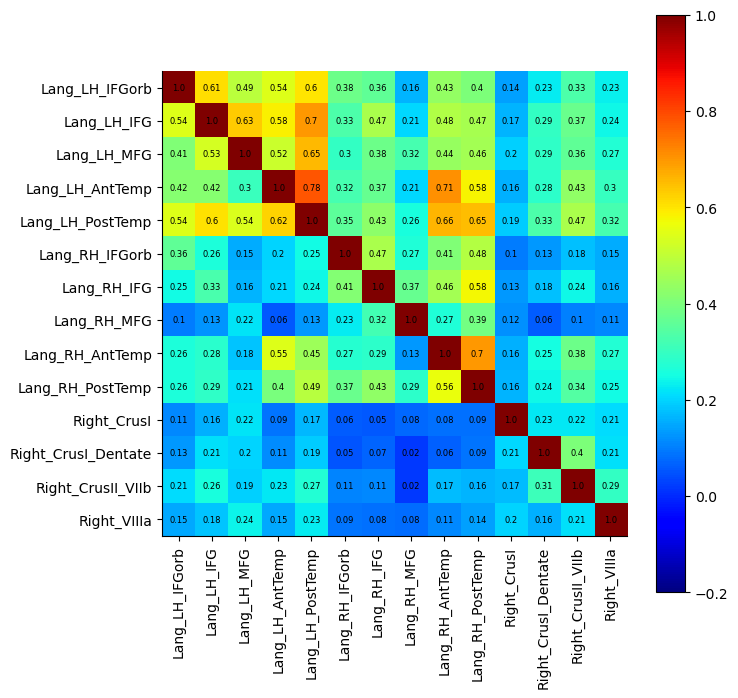

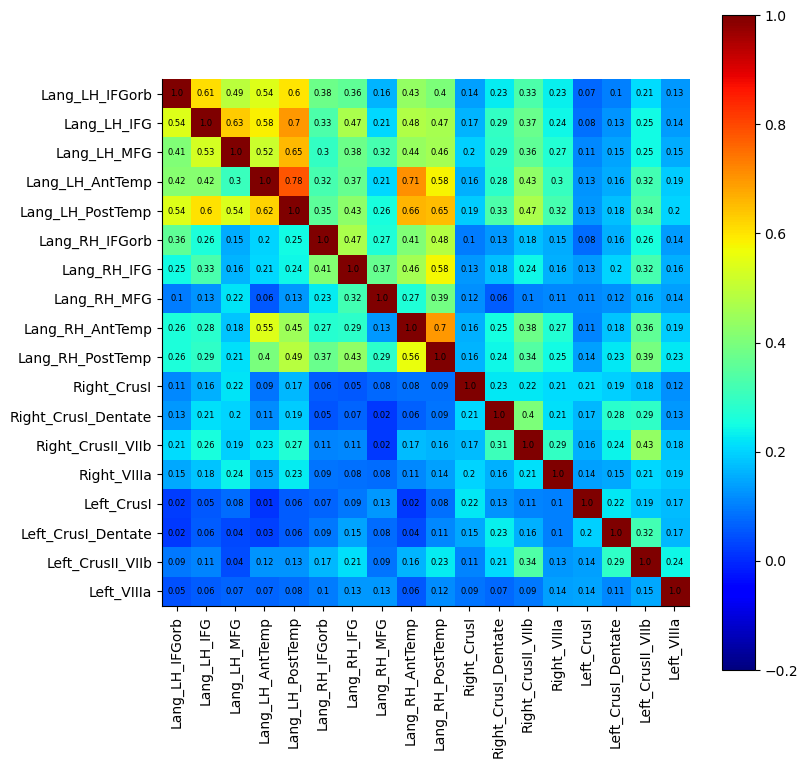

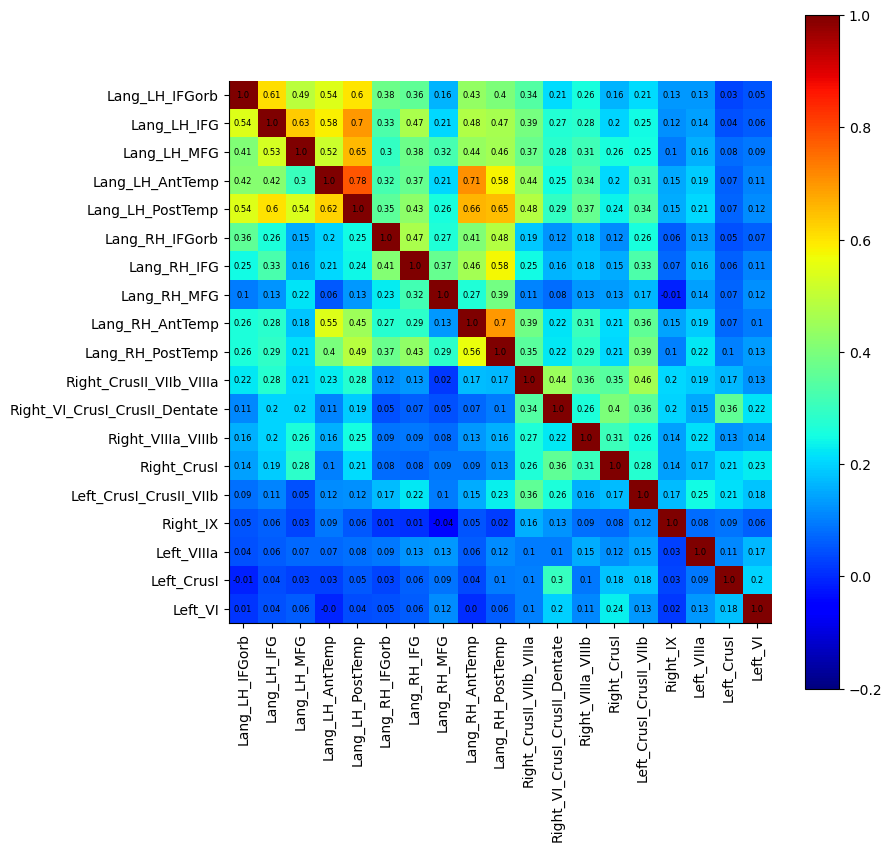

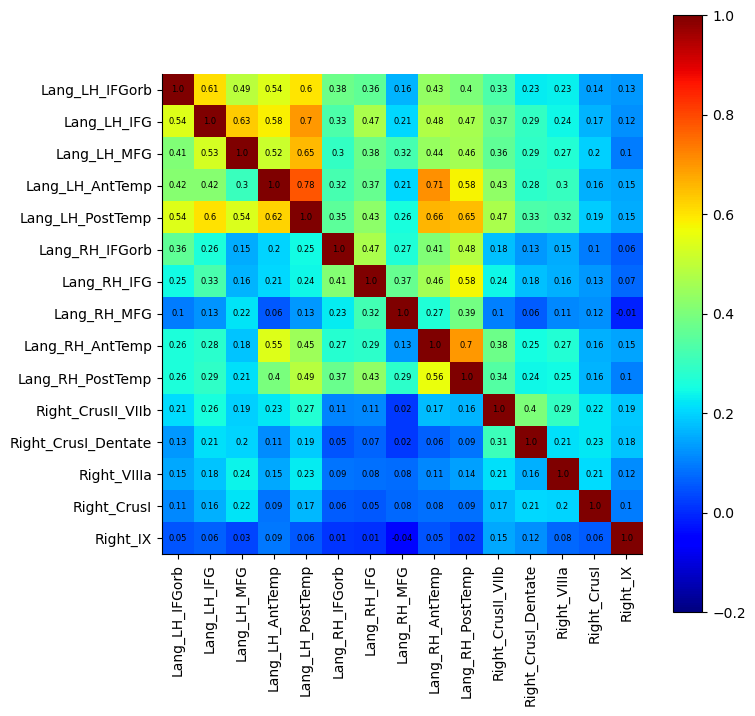

In [4]:
def mean_tanh(x):
    return np.tanh(np.mean(x)) 

# plot correlation heatmaps DIFFERENT UPPER/LOWER TRIANGLE
for system in systems: 

    all_data = []
    for task in ['AliceLong','RS']:
    
        # load data
        system_string = '_'.join(system)
        data = pd.read_csv('Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficients_no_fixation.csv',index_col=[0,1])
        data = data.drop(columns=['Lang_LH_AngG','Lang_RH_AngG'])
        data = data.drop(index=['Lang_LH_AngG','Lang_RH_AngG'],level=1)

        # average over subjects
        data_vals = data.groupby('ROIs', sort=False).mean()
        if system_string=='LangLoc_Cerebellum1': # reorder cerebellum ROIs
            columns = data_vals.columns
            columns = columns[np.append(np.arange(0,10),[13,11,10,12])]
            data_vals = data_vals.reindex(columns=columns, index=columns)
        elif system_string=='LangLoc_Cerebellum2': # reorder cerebellum ROIs
            columns = data_vals.columns
            columns = columns[np.append(np.arange(0,10),[13,11,10,12,17,15,14,16])]
            data_vals = data_vals.reindex(columns=columns, index=columns)
        else:
            columns = data.columns
        data_vals = data_vals.values
        # data_vals = data.groupby('ROIs', sort=False).agg([mean_tanh]).values
        data_vals[np.isnan(data_vals)]=1
        all_data.append(data_vals)
        nROIs = data_vals.shape[0]

    # combine data from two tasks into same matrix
    data_vals = np.sum([np.triu(all_data[0]),np.tril(all_data[1],-1)],axis=0)
    
    # plot
    plt.ion()
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    plt.rc('font',**{'family':'sans-serif'})
    plt.rc('pdf', **{'fonttype':42})
    fig,ax = plt.subplots(figsize=(0.25*nROIs+4,0.25*nROIs+4))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.imshow(data_vals,cmap='jet',vmin = -0.2,vmax = 1)
    plt.colorbar()
    ax.set_xticks(np.arange(0,nROIs),columns,fontsize=10,rotation=90)
    ax.set_yticks(np.arange(0,nROIs),columns,fontsize=10)

    for i in range(0,nROIs):
        for j in range(0,nROIs):
            ax.text(i,j,round(data_vals[j,i],2),ha='center',va='center',fontsize=6)
        
    # save plot
    if not os.path.exists('plots/'):
        os.makedirs('plots/')
    save_filename = 'plots/Alice_AliceLong_and_RS_FunctionalConnectivity_'+system_string+'_correlation_coefficients_no_fixation.pdf'
    plt.savefig(save_filename,format='pdf',bbox_inches='tight',pad_inches=0.5)

In [5]:
lang_LH = ['Lang_LH_IFGorb','Lang_LH_IFG','Lang_LH_MFG','Lang_LH_AntTemp','Lang_LH_PostTemp']
lang_RH = ['Lang_RH_IFGorb','Lang_RH_IFG','Lang_RH_MFG','Lang_RH_AntTemp','Lang_RH_PostTemp']
cereb_RH = ['Right_CrusII_VIIb','Right_CrusI_Dentate','Right_VIIIa','Right_CrusI']
cereb_LH = ['Left_CrusII_VIIb','Left_CrusI_Dentate','Left_VIIIa','Left_CrusI']
MD = ['MD_LH_postParietal','MD_LH_midParietal','MD_LH_antParietal','MD_LH_supFrontal','MD_LH_Precentral A PrecG','MD_LH_Precentral B IFGop','MD_LH_midFrontal','MD_LH_midFrontalOrb','MD_LH_insula','MD_LH_medialFrontal',
      'MD_RH_postParietal','MD_RH_midParietal','MD_RH_antParietal','MD_RH_supFrontal','MD_RH_Precentral A PrecG','MD_RH_Precentral B IFGop','MD_RH_midFrontal','MD_RH_midFrontalOrb','MD_RH_insula','MD_RH_medialFrontal']
cereb_RH_IX = ['Right_IX']

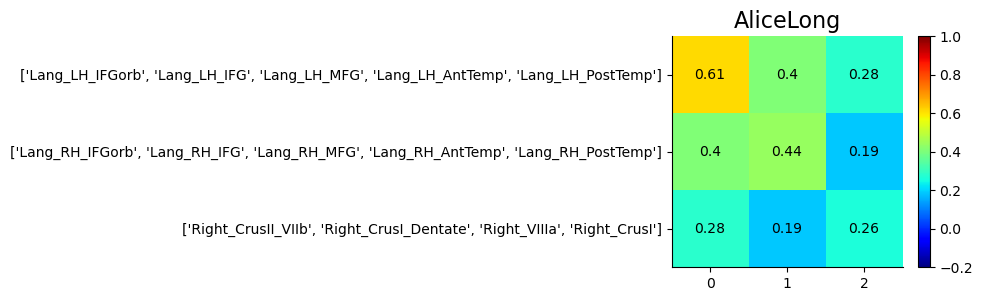

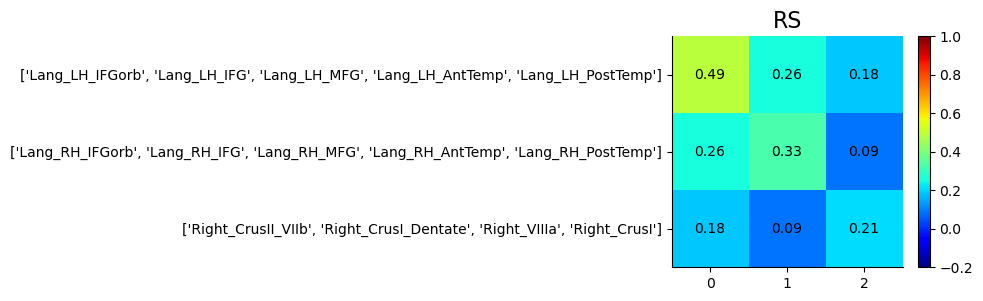

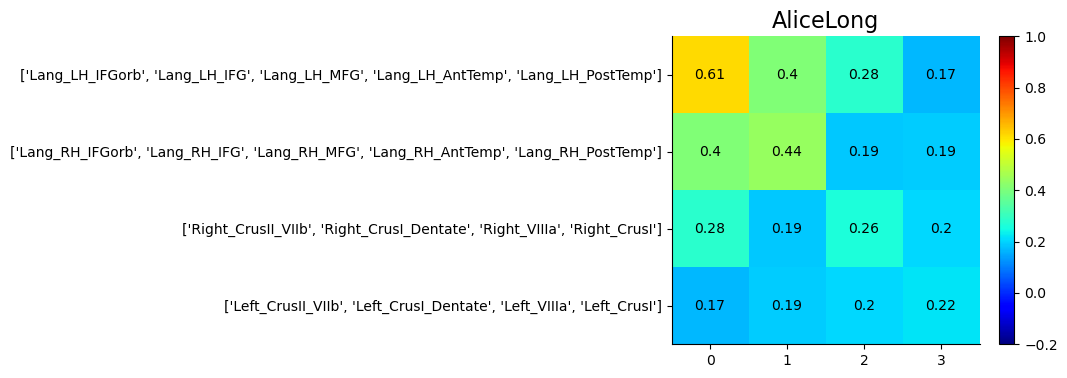

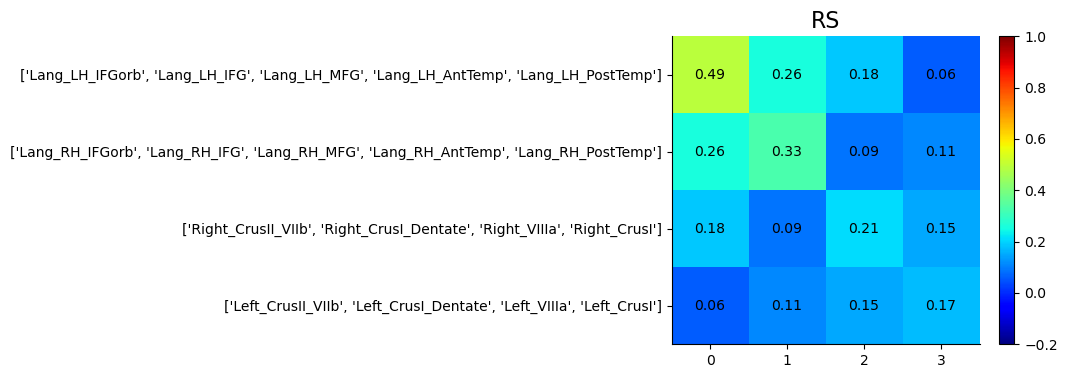

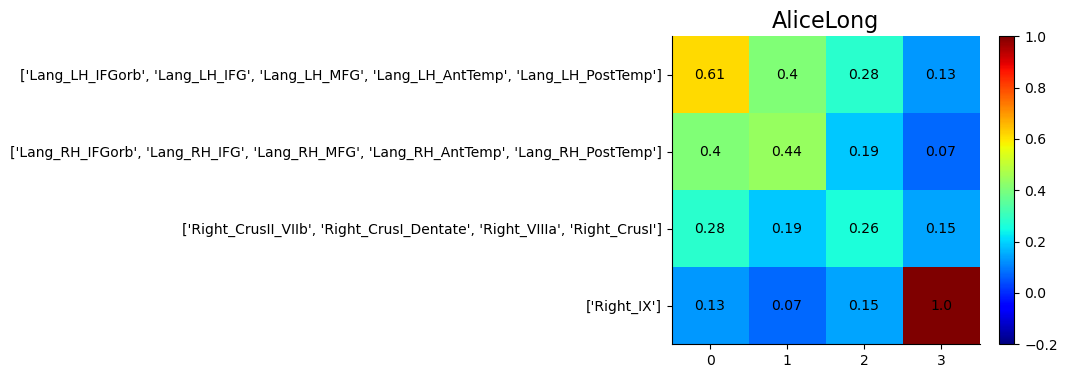

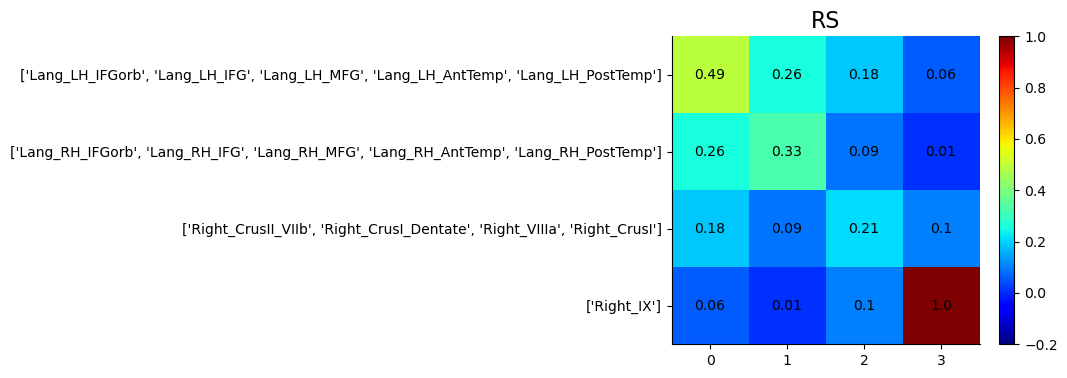

In [6]:
# summary plot
systems = [['LangLoc','Cerebellum1'],
           ['LangLoc','Cerebellum2'],
           ['LangLoc','Cerebellum4']]
comparisons = [[lang_LH,lang_RH,cereb_RH],
               [lang_LH,lang_RH,cereb_RH,cereb_LH],
               [lang_LH,lang_RH,cereb_RH,cereb_RH_IX]]
comparison_labels =  [['lang_LH','lang_RH','cereb_RH'],
                      ['lang_LH','lang_RH','cereb_RH','cereb_LH'],
                      ['lang_LH','lang_RH','cereb_RH','Right_IX']]

for s,system in enumerate(systems):
    comparison = comparisons[s]
    comparison_label = comparison_labels[s]
    
    for task in ['AliceLong','RS']:
    
        system_string = '_'.join(system)
        
        # load data
        data = pd.read_csv('Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficients_no_fixation.csv',index_col=[0,1])

        # plot
        plt.ion()
        plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
        plt.rc('font',**{'family':'sans-serif'})
        plt.rc('pdf', **{'fonttype':42})
        fig,ax = plt.subplots(figsize=(1+len(comparison),len(comparison)))

        corrs_all = np.zeros((len(comparison),len(comparison)))
        for c1,comparison1 in enumerate(comparison):
            for c2,comparison2 in enumerate(comparison):
                col_idxs = [True if col in comparison1 else False for col in data.columns]
                row_idxs = [True if col in comparison2 else False for col in data.columns]
                assert(np.sum(col_idxs)==len(comparison1))
                assert(np.sum(row_idxs)==len(comparison2))
                
                for s,sub in enumerate(data.index.levels[0]):
                    data_sub = data.loc[sub]
                
                    corrs = data_sub.loc[row_idxs,col_idxs].values
                    if (comparison1==['Right_IX']) & (comparison2==['Right_IX']):
                        corrs_all[c1,c2] += 1
                    else:
                        if comparison1==comparison2:
                            corrs = corrs[np.nonzero(np.triu(corrs,1))]
                        corrs_all[c1,c2] += np.mean(corrs)
                
        # average over subjects
        corrs_all = corrs_all/len(data.index.levels[0])

        # plot 
        plt.imshow(corrs_all,cmap='jet',vmin = -0.2,vmax = 1)
        plt.colorbar()
        ax.set_yticks(np.arange(0,len(comparison)),comparison,fontsize=10)
        plt.title(task,fontsize=16)

        for i in range(0,len(comparison)):
            for j in range(0,len(comparison)):
                ax.text(i,j,round(corrs_all[j,i],2),ha='center',va='center',fontsize=10)
        
        # save plot
        save_filename = 'plots/Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficients_summary_no_fixation.pdf'
        plt.savefig(save_filename,format='pdf',bbox_inches='tight',pad_inches=0.5)
        save_filename = 'plots/Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficients_summary_no_fixation.svg'
        plt.savefig(save_filename,format='svg',bbox_inches='tight',pad_inches=0.5)

In [7]:
cereb_RH_roi1 = ['Right_CrusII_VIIb']
cereb_RH_roi2 = ['Right_CrusI_Dentate']
cereb_RH_roi3 = ['Right_VIIIa']
cereb_RH_roi4 = ['Right_CrusI']

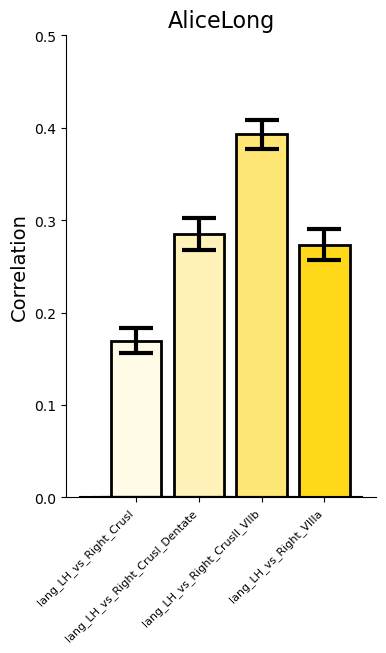

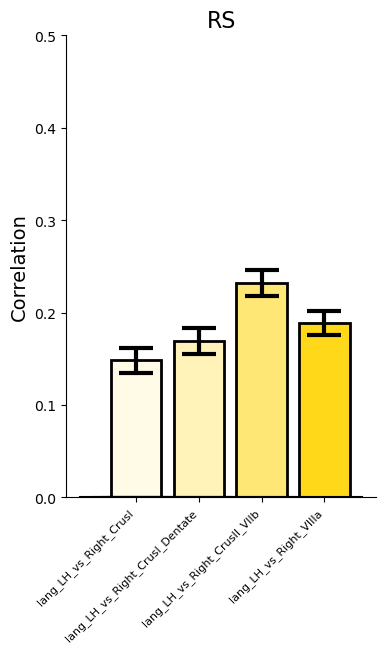

In [8]:
# summary plot
systems = [['LangLoc','Cerebellum1']]
comparisons = [[lang_LH,cereb_RH_roi4],
               [lang_LH,cereb_RH_roi2],
               [lang_LH,cereb_RH_roi1],
               [lang_LH,cereb_RH_roi3]]
comparison_labels = ['lang_LH_vs_Right_CrusI',
                     'lang_LH_vs_Right_CrusI_Dentate',
                     'lang_LH_vs_Right_CrusII_VIIb',
                     'lang_LH_vs_Right_VIIIa']

for task in ['AliceLong','RS']:

    for system in systems:
        system_string = '_'.join(system)
        
        # load data
        data = pd.read_csv('Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficients_no_fixation.csv',index_col=[0,1])
    
        # plot
        plt.ion()
        plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
        plt.rc('font',**{'family':'sans-serif'})
        plt.rc('pdf', **{'fonttype':42})
        fig,ax = plt.subplots(figsize=(len(comparisons),6))
        xtickvalues = []
        sliding_x = 1
        
        for c,comparison in enumerate(comparisons):
            col_idxs = [True if col in comparison[0] else False for col in data.columns]
            row_idxs = [True if col in comparison[1] else False for col in data.columns]
            assert(np.sum(col_idxs)==len(comparison[0]))
            assert(np.sum(row_idxs)==len(comparison[1]))

            corrs_all = []
            for s,sub in enumerate(data.index.levels[0]):
                data_sub = data.loc[sub]
            
                corrs = data_sub.loc[row_idxs,col_idxs].values
                if comparison[0]==comparison[1]:
                    corrs = corrs[np.nonzero(np.triu(corrs,1))]
                else:
                    corrs = corrs[np.nonzero(np.triu(corrs))]
                corrs_all.append(np.mean(corrs))

            # average over subjects
            assert len(corrs_all)==len(data.index.levels[0])
            cmap = matplotlib.colormaps.get_cmap('jet')
            colors = [
                (1.0, 0.8470588235294118, 0.09803921568627451, 0.1),
                (1.0, 0.8470588235294118, 0.09803921568627451, 0.3),
                (1.0, 0.8470588235294118, 0.09803921568627451, 0.6),
                (1.0, 0.8470588235294118, 0.09803921568627451, 1.0)
            ]
            
            plt.bar(x=sliding_x,
                    height=np.mean(corrs_all),
                    yerr=np.std(corrs_all)/np.sqrt(len(corrs_all)),
                    edgecolor='k',
                    linewidth=2,
                    color=colors[c],
                    capsize=12,
                    error_kw={'elinewidth' : 3, 'capthick' : 3}
            )
    
            # plt.scatter(np.array([sliding_x]*len(corrs_all)),
            #             np.tanh(corrs_all),
            #             s=np.array([60]*len(corrs_all)),
            #             c='dimgray',
            #             edgecolors='k',
            #             alpha=0.7
            # )

            xlims = plt.xlim()
            plt.plot(xlims,[0, 0],'k')
            plt.ylim([0,0.5])
            xtickvalues.append(sliding_x)
            sliding_x = sliding_x+1

        plt.xticks(xtickvalues,comparison_labels,rotation=45,fontsize=8,ha='right')
        plt.ylabel('Correlation',fontsize=14)
        plt.title(task,fontsize=16)
        
        # save plot
        save_filename = 'plots/Alice_'+task+'_FunctionalConnectivity_'+system_string+'_correlation_coefficients_LangLH_vs_CerebRH_summary_no_fixation.pdf'
        plt.savefig(save_filename,format='pdf',bbox_inches='tight',pad_inches=0.5)